# Ion Temperature Gradient Drift Dispersion (Kappa Distribution)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plasmapy
from scipy import special as sp
import scipy.optimize as op
from tqdm import tqdm
%config InlineBackend.figure_format = 'svg'

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})

In [3]:
mi2me = 1836
ve2vi = 150
L_t2rho_i = 10
wp_i2wc_i = 100
ky_rho_i = 0.1

terms = 300 # number of terms for the integration

In [4]:
def w_re(z):
    return np.real(-0.5*plasmapy.dispersion.plasma_dispersion_func_deriv(z/np.sqrt(2)))

def SolveParameters(zi,ky_rho_i,kappa_i):
    gl_1 = sp.roots_genlaguerre(terms,kappa_i-0.5)
    gl_2 = sp.roots_genlaguerre(terms,kappa_i-1.5)

    A1_integrad = lambda bi: (w_re(zi*np.sqrt(bi)) - 1.0) * sp.ive(0,ky_rho_i**2/bi)
    A1 = np.dot(gl_1[1],A1_integrad(gl_1[0]/kappa_i))/sp.gamma(kappa_i+0.5)

    A2_integrad = lambda bi: (w_re(zi*np.sqrt(bi)) - 1.0) * sp.ive(0,ky_rho_i**2/bi)
    A2 = np.dot(gl_2[1],A2_integrad(gl_2[0]/kappa_i))/sp.gamma(kappa_i+0.5)*(kappa_i-1.5)

    A3_integrad = lambda bi:-0.5*zi**2*bi*w_re(zi*np.sqrt(bi)) * sp.ive(0,ky_rho_i**2/bi) - (w_re(zi*np.sqrt(bi)) - 1.0) * (sp.ive(1,ky_rho_i**2/bi)-sp.ive(0,ky_rho_i**2/bi))*ky_rho_i**2/bi
    A3 = np.dot(gl_2[1],A3_integrad(gl_2[0]/kappa_i))/sp.gamma(kappa_i+0.5)*(kappa_i-1.5)
    
    B1_integrad = lambda bi: np.sqrt(bi)*np.exp(-0.5*zi**2*bi)*sp.ive(0,ky_rho_i**2/bi)
    B1 = np.dot(gl_1[1],B1_integrad(gl_1[0]/kappa_i))/sp.gamma(kappa_i+0.5)

    B2_integrad = lambda bi: np.sqrt(bi)*np.exp(-0.5*zi**2*bi)*sp.ive(0,ky_rho_i**2/bi)
    B2 = np.dot(gl_2[1],B2_integrad(gl_2[0]/kappa_i))/sp.gamma(kappa_i+0.5)*(kappa_i-1.5)

    D2_integrad = lambda bi: bi**(1.5)*np.exp(-0.5*zi**2*bi)*sp.ive(0,ky_rho_i**2/bi)
    D2 = np.dot(gl_2[1],D2_integrad(gl_2[0]/kappa_i))/sp.gamma(kappa_i+0.5)*(kappa_i-1.5)

    E_integrad = lambda bi: np.exp(-0.5*zi**2*bi)/np.sqrt(bi)*(sp.ive(1,ky_rho_i**2/bi)-sp.ive(0,ky_rho_i**2/bi))
    E = np.dot(gl_2[1],E_integrad(gl_2[0]/kappa_i))/sp.gamma(kappa_i+0.5)*(kappa_i-1.5)

    return A1,A2,A3,B1,B2,D2,E

def z_cr_eq(z,kappa_i):
    A1,A2,A3,B1,B2,D2,E = SolveParameters(z,ky_rho_i,kappa_i)
    wt2w = -(kappa_i/(kappa_i-0.5)*mi2me/ve2vi**2+1.0+A1)/(0.5*A2+A3)
    r = kappa_i/(kappa_i-0.5)*mi2me/ve2vi**3 + B1 + wt2w*(0.5*B2 - 0.5*z**2*D2 - E*ky_rho_i**2)
    return r

def kzrhoi_cr(z,kappa_i):
    A1,A2,A3,B1,B2,D2,E = SolveParameters(z,ky_rho_i,kappa_i)
    wt2wc = kappa_i/(kappa_i-1.5)*ky_rho_i/L_t2rho_i
    r = - wt2wc/z * (0.5*A2 + A3) / (kappa_i/(kappa_i-0.5)*mi2me/ve2vi**2 + 1.0 + A1)
    return r

def z_cr_eq_approx(z,kappa_i):
    A1,A2,A3,B1,B2,D2,E = SolveParameters(z,0,kappa_i)
    wt2w = (1.0/z**2-mi2me/ve2vi**2)/(1.0/z**2-ky_rho_i**2)
    r = kappa_i/(kappa_i-0.5)*mi2me/ve2vi**3 + wt2w*(0.5*B2-0.5*z**2*D2-E*ky_rho_i**2)
    return r

def kzrhoi_cr_approx(z,kappa_i):
    wt2wc = kappa_i/(kappa_i-1.5)*ky_rho_i/L_t2rho_i
    r = wt2wc/z*(z**(-2)-ky_rho_i**2)/(z**(-2)-mi2me/ve2vi**2)
    return r

In [5]:
kappa_i_list = np.linspace(1.8, 5.5, 50)
kz_rho_i_lo_list = []
kz_rho_i_up_list = []
mth = 'hybr'
z_lo_g = 13
z_up_g = 1

for kappa_i in tqdm(kappa_i_list):
    s_lo = op.root(z_cr_eq,z_lo_g,args=(kappa_i),method=mth)
    if s_lo.success:
        kzrhoi_lo = kzrhoi_cr(s_lo.x,kappa_i)
        kz_rho_i_lo_list.append(kzrhoi_lo)
        z_lo_g = s_lo.x[0]*0.99

    s_up = op.root(z_cr_eq,z_up_g,args=(kappa_i),method=mth)
    if s_up.success:
        kzrhoi_up = kzrhoi_cr(s_up.x,kappa_i)
        kz_rho_i_up_list.append(kzrhoi_up)
        z_up_g = s_up.x[0]*0.99

100%|██████████| 50/50 [00:03<00:00, 13.13it/s]


In [6]:
def PDRMK(w2wc,kz_rho_i,kappa_i,gl_1,gl_2):
    fki = np.sqrt(kappa_i/(kappa_i-0.5))
    ky2kz = ky_rho_i/kz_rho_i
    ky_rho_e = ky_rho_i*ve2vi/mi2me
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i*fki
    k_l_De = k_l_Di*ve2vi/np.sqrt(mi2me)/fki
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/ve2vi
    zeta_ni = 0
    zeta_ti = 1.0/np.sqrt(2)*ky2kz/L_t2rho_i*kappa_i/(kappa_i-1.5)

    K1_integrad = lambda bi: np.sqrt(bi) * ( zeta_i - zeta_ni*(kappa_i-3/2)/kappa_i/bi + 0.5*zeta_ti*(kappa_i-3/2)/kappa_i/bi )*plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi))*sp.ive(0,ky_rho_i**2/bi)

    K2_integrad = lambda bi: zeta_ti * ( 0.5*zeta_i*bi*plasmapy.dispersion.plasma_dispersion_func_deriv(zeta_i*np.sqrt(bi))*sp.ive(0,ky_rho_i**2/bi) - plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi)) * ky_rho_i**2/np.sqrt(bi) * (sp.ive(1,ky_rho_i**2/bi)-sp.ive(0,ky_rho_i**2/bi)) )

    ri1 =  np.dot(gl_1[1],K1_integrad(gl_1[0]/kappa_i))/sp.gamma(kappa_i+0.5)
    ri2 =  np.dot(gl_2[1],K2_integrad(gl_2[0]/kappa_i))/sp.gamma(kappa_i+0.5)*(kappa_i-1.5)

    re = 1 + (zeta_e)*plasmapy.dispersion.plasma_dispersion_func(zeta_e)*sp.ive(0,ky_rho_e**2)
    ri = 1.0 + ri1 + ri2
    r =  1.0 + re/k_l_De**2 + ri/k_l_Di**2

    return [r.real,r.imag]

In [7]:
ks_pow = -5
ke_pow = -1.5
ks = 10**ks_pow
ke = 10**ke_pow
pow_idx = np.linspace(ks_pow,ke_pow,num=500)
kz_rho_i_list = 10**pow_idx

wguess_k = 1e-4
rguess_k = -1e-7

kappa_i_points = np.linspace(2,5,6)

In [8]:
kz_rho_i_lo_list_PDR = []
kz_rho_i_up_list_PDR = []

for kappa_i in tqdm(kappa_i_points):
    w_MK_list = []
    r_MK_list = []
    kz_cr = []

    wgmk =wguess_k
    rgmk =rguess_k

    gl_1 = sp.roots_genlaguerre(terms,kappa_i-0.5)
    gl_2 = sp.roots_genlaguerre(terms,kappa_i-1.5)

    for ki in kz_rho_i_list:
        sMK=op.root(lambda w:PDRMK(w,ki,kappa_i,gl_1,gl_2),[wgmk,rgmk],method=mth)
        w_MK_list.append(sMK.x[0])
        r_MK_list.append(sMK.x[1])
        wgmk = sMK.x[0]*0.7
        rgmk = sMK.x[1]*0.6

    for i in range(len(r_MK_list)-1):
        if r_MK_list[i]*r_MK_list[i+1]<0:
            kz_cr.append(0.5*(kz_rho_i_list[i]+kz_rho_i_list[i+1]))

    kz_rho_i_lo_list_PDR.append(kz_cr[0])
    kz_rho_i_up_list_PDR.append(kz_cr[1])

100%|██████████| 6/6 [00:09<00:00,  1.60s/it]


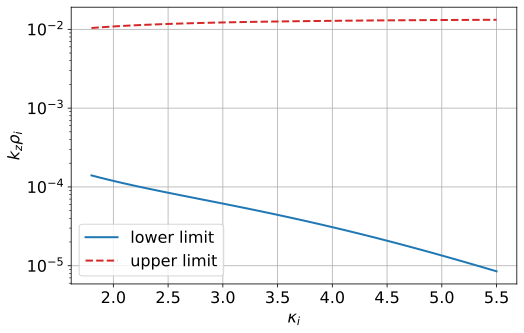

In [9]:
fig = plt.figure(figsize=(8,5))

plt.plot(kappa_i_list,kz_rho_i_lo_list, label=r'lower limit', color='tab:blue', linestyle='-')
plt.plot(kappa_i_list,kz_rho_i_up_list, label=r'upper limit', color='tab:red', linestyle='--')
# plt.scatter(kappa_i_points,kz_rho_i_lo_list_PDR, color='tab:green', marker='x')
# plt.scatter(kappa_i_points,kz_rho_i_up_list_PDR, color='tab:green', marker='x')

plt.xlabel(r'$\kappa_i$')
plt.ylabel(r'$k_z\rho_i$')
plt.yscale('log')
plt.grid()
plt.legend()

# plt.savefig('./fig4_critical_kz_vs_kappai.pdf', bbox_inches='tight')
plt.show()